In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

**Cancer Dataset**

In this project, I am employing two different models: CNN and RNN (LSTM), to analyze descriptions provided by doctors related to three different types of cancer.

Overall, the dataset contains 7000 entries. However, I have chosen to work with only 4000 entries to expedite the training process.

The final conclusions are as follows:

    Accuracy for CNN: 99%
    Accuracy for LSTM: 95%

It's evident that the CNN model outperforms LSTM in text predictions.

In [3]:
df = pd.read_csv('dataset.csv', header = None, encoding='latin1')

df.head()


,0,1,2
0,S0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [4]:
df = df[[1,2]]

In [5]:
df.head()

,1,2
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [6]:
df.columns=['labels','text']

In [7]:
df.head()

,labels,text
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [8]:
df.isnull().sum()

labels    0
text      0
dtype: int64

In [9]:
# Checking the length of the data set
print(len(df))

7570


In [10]:
# Reducing the size of the dataset, selecting only 10k
df = df.sample(4000)

In [11]:
df.sample(10)

,labels,text
7410,Colon_Cancer,""" ovarian cancer is the second most common gy..."
2028,Colon_Cancer,"""tea is the second most popular beverage consu..."
2419,Lung_Cancer,"""To understand the functional consequences of ..."
7329,Colon_Cancer,""" african americans aa are at high risk for c..."
160,Thyroid_Cancer,"""researchWhat are the implications of using in..."
1458,Colon_Cancer,""" ethnopharmacological relevance herba patr..."
3256,Thyroid_Cancer,"""Severe COVID19 has a high mortality rate Comp..."
2060,Lung_Cancer,"""NSCLC and 40 healthy controls were collected...."
5930,Colon_Cancer,""" in the current research we have developed s..."
2427,Lung_Cancer,""" Materials and Methods We examined the anti-t..."


In [12]:
df['targets'] = df['labels'].astype('category').cat.codes

In [13]:
df.sample(10)

,labels,text,targets
2753,Thyroid_Cancer,The Adler grade by Doppler ultrasound isassoc...,2
5288,Lung_Cancer,"""We also evaluated chest CT findings to determ...",1
5834,Colon_Cancer,""" the ampactivated protein kinase ampk is an ...",0
6393,Colon_Cancer,""" many suggest that shared decisionmaking sdm...",0
4845,Colon_Cancer,""" mutations in the wilms tumor gene cause a ...",0
5268,Lung_Cancer,"""which contains an SH2 domain and two SH3 doma...",1
2626,Thyroid_Cancer,immuneï¿½related genes pairs signature predi...,2
889,Lung_Cancer,"""Median PFS in patients with EGFR mutation?pos...",1
2474,Lung_Cancer,"""CR1 also modulates the complement cascade act...",1
3504,Colon_Cancer,during the last decade green synthesized ceri...,0


In [14]:
df['labels'].value_counts()

labels
Thyroid_Cancer    1503
Colon_Cancer      1340
Lung_Cancer       1157
Name: count, dtype: int64

In [15]:
# Number of classes
K = df['targets'].max() + 1
K

3

In [16]:
from sklearn.model_selection import train_test_split

random_seed = 42

df_train, df_test = train_test_split(df, test_size=0.3, random_state=random_seed)

In [17]:
# Convert sentences to sequences - keeps 2000 most frequent and discard the rest.
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

# Builds the vocabulary based on the most common words. It assigns a unique integer to each word based on its frequency
tokenizer.fit_on_texts(df_train['text'])

# Each word in the sentences is replaced by its corresponding integer based on the vocabulary created by the tokenizer.
sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [18]:
# get total unique words mapped by tokenizer (True size of our unique words)
word2idx = tokenizer.word_index
V = len(word2idx)
print(f'Found unique words: {V}')

Found unique words: 201521


In [19]:
# pad sequences so we get a N x T matrix - all the text must have same dimension size
data_train = pad_sequences(sequences_train)
print(f'Shape of data train tensor: {data_train.shape}')

Shape of data train tensor: (2800, 4395)


In [20]:
data_train

array([[   0,    0,    0, ...,  283,    2,   14],
       [   0,    0,    0, ...,    5,    3, 1217],
       [   0,    0,    0, ...,    1,  719,    2],
       ...,
       [   0,    0,    0, ...,    7,  178,    4],
       [   0,    0,    0, ...,  379,   29,    1],
       [   0,    0,    0, ..., 1068,   14,   72]])

In [21]:
# Get sequences length
T = data_train.shape[1]
T

4395

In [22]:
data_test = pad_sequences(sequences_test, maxlen=T)
print(f'Shape of data test tensor: {data_test.shape}')

Shape of data test tensor: (1200, 4395)


In [23]:
# Creating the CNN model

# Choosing embedding dimensionality
D = 30

i = Input(shape=(T,))
x = Embedding(V+ 1 ,D)(i)
x = Conv1D(32,2, strides=1 ,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64,3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x) # where K is the total of news's labels

model = Model(i,x)

In [24]:
# Compile and Fit the model
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

print('Training the model...')
r = model.fit(
    data_train,
    df_train['targets'],
    epochs = 20,
    validation_data=(data_test, df_test['targets'])
)


Training the model...
Epoch 1/20


88/88 [==============================] - 4s 41ms/step - loss: 1.0273 - accuracy: 0.4236 - val_loss: 0.7741 - val_accuracy: 0.7875
Epoch 2/20
88/88 [==============================] - 3s 38ms/step - loss: 0.4347 - accuracy: 0.8361 - val_loss: 0.3289 - val_accuracy: 0.8617
Epoch 3/20
88/88 [==============================] - 3s 38ms/step - loss: 0.2900 - accuracy: 0.8732 - val_loss: 0.2553 - val_accuracy: 0.9058
Epoch 4/20
88/88 [==============================] - 3s 38ms/step - loss: 0.1653 - accuracy: 0.9482 - val_loss: 0.1217 - val_accuracy: 0.9675
Epoch 5/20
88/88 [==============================] - 3s 38ms/step - loss: 0.0707 - accuracy: 0.9857 - val_loss: 0.0646 - val_accuracy: 0.9867
Epoch 6/20
88/88 [==============================] - 3s 38ms/step - loss: 0.0366 - accuracy: 0.9914 - val_loss: 0.0416 - val_accuracy: 0.9883
Epoch 7/20
88/88 [==============================] - 3s 38ms/step - loss: 0.0228 - accuracy: 0.9939 - val_loss: 0.0331 - val_accur

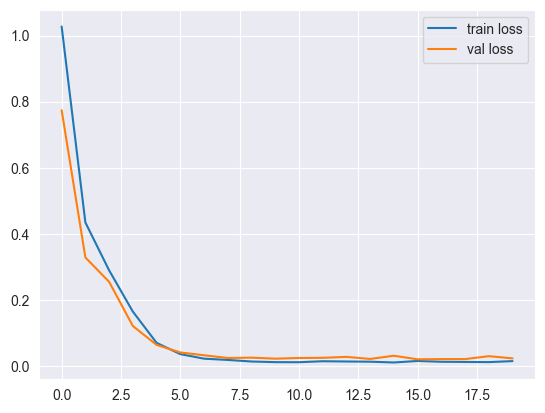

In [25]:
# Checking loss per itartion
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

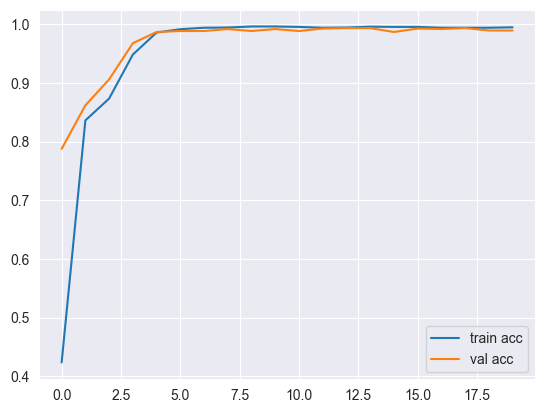

In [26]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [27]:

from sklearn.metrics import classification_report


predictions = model.predict(data_test)
y_pred = np.argmax(predictions, axis=1)  # Convert logits to class labels

# Get true labels
y_true = df_test['targets']

# Generate classification report
report = classification_report(y_true, y_pred)
print(report)




38/38 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       402
           1       1.00      0.99      0.99       352
           2       0.98      1.00      0.99       446

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



In [28]:
classes = df['targets'].unique()

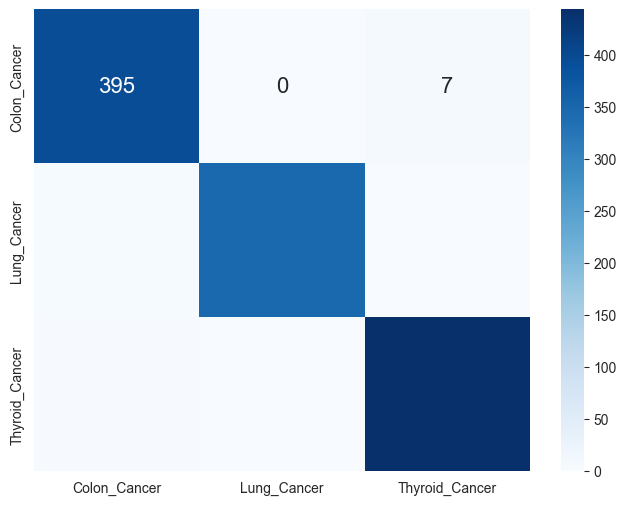

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_mapping = {
    0: 'Colon_Cancer',
    1: 'Lung_Cancer',
    2: 'Thyroid_Cancer'
    
}
marks = np.arange(len(label_mapping))

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=[label_mapping[i] for i in label_mapping] , columns = [label_mapping[i] for i in label_mapping])

plt.figure(figsize=(8, 6))
plt.xlabel('Predicted')
plt.ylabel('True')
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues')

plt.show()

In [30]:
# Creating the model for RNN (LSTM)

i = Input(shape=(T,)) # T = Sequence Length
x = Embedding(V+1,D)(i) # symbolic representation of the input data that will be passed through the layers of the neural network
x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(K)(x)

model = Model(i,x)



In [31]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')

r_rnn = model.fit(
  data_train,
  df_train['targets'],
  epochs=20,
  validation_data=(data_test, df_test['targets'])
)

Training model...
Epoch 1/20
88/88 [==============================] - 110s 1s/step - loss: 0.9589 - accuracy: 0.4950 - val_loss: 1.8072 - val_accuracy: 0.2958
Epoch 2/20
88/88 [==============================] - 109s 1s/step - loss: 0.7241 - accuracy: 0.7193 - val_loss: 0.5142 - val_accuracy: 0.8833
Epoch 3/20
88/88 [==============================] - 108s 1s/step - loss: 0.4875 - accuracy: 0.8743 - val_loss: 0.4434 - val_accuracy: 0.8808
Epoch 4/20
88/88 [==============================] - 107s 1s/step - loss: 0.4514 - accuracy: 0.8679 - val_loss: 0.3910 - val_accuracy: 0.8833
Epoch 5/20
88/88 [==============================] - 107s 1s/step - loss: 0.3512 - accuracy: 0.8893 - val_loss: 0.3264 - val_accuracy: 0.9008
Epoch 6/20
88/88 [==============================] - 106s 1s/step - loss: 0.2857 - accuracy: 0.9189 - val_loss: 0.2727 - val_accuracy: 0.9200
Epoch 7/20
88/88 [==============================] - 106s 1s/step - loss: 0.2284 - accuracy: 0.9371 - val_loss: 0.2257 - val_accuracy: 0.

In [32]:
predictions = model.predict(data_test)
y_pred = np.argmax(predictions, axis=1)  # Convert logits to class labels

# Get true labels
y_true = df_test['targets']

# Generate classification report
report = classification_report(y_true, y_pred)
print(report)

38/38 [==============================] - 10s 261ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       402
           1       1.00      1.00      1.00       352
           2       0.97      0.98      0.97       446

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



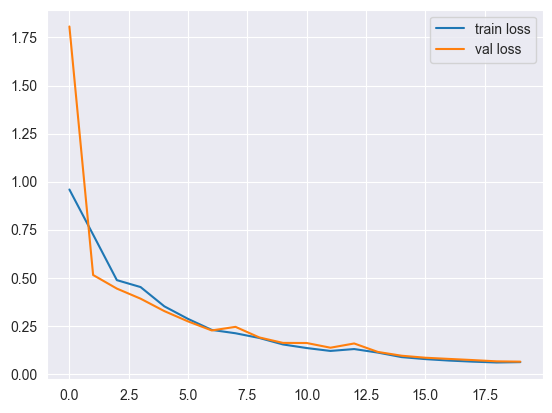

In [33]:
# Checking loss per itartion
plt.plot(r_rnn.history['loss'], label='train loss')
plt.plot(r_rnn.history['val_loss'], label='val loss')
plt.legend();

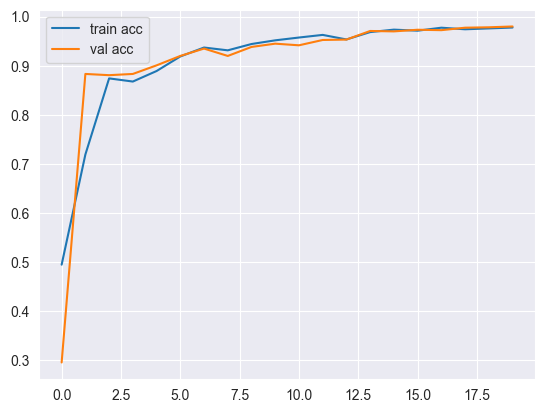

In [34]:
# Plot accuracy per iteration
plt.plot(r_rnn.history['accuracy'], label='train acc')
plt.plot(r_rnn.history['val_accuracy'], label='val acc')
plt.legend();

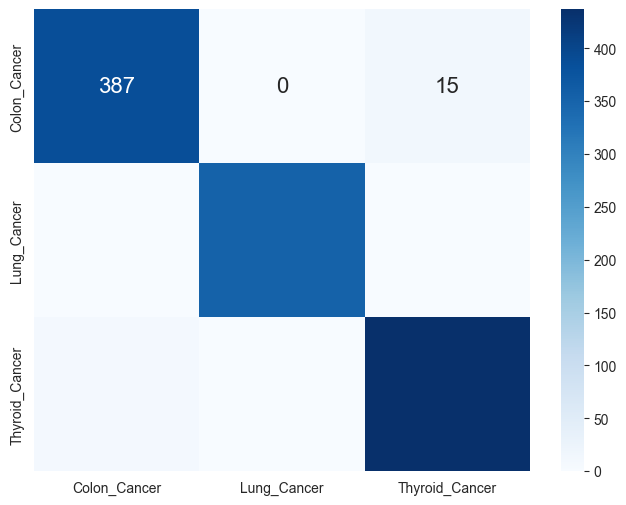

In [35]:
label_mapping = {
    0: 'Colon_Cancer',
    1: 'Lung_Cancer',
    2: 'Thyroid_Cancer'
    
}
marks = np.arange(len(label_mapping))

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=[label_mapping[i] for i in label_mapping] , columns = [label_mapping[i] for i in label_mapping])

plt.figure(figsize=(8, 6))
plt.xlabel('Predicted')
plt.ylabel('True')
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues')

plt.show()

In [37]:
# Save the model
model.save('model.h5')
model.save('model.keras')

C:\Users\irfan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
